In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

# PySpark specific imports
from pyspark.sql.functions import col, isnan, when, count, udf
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Special version of pandas for spark
# from pyspark import pandas as ps
# ps.set_option('display.max_rows', 10)

# Sklearn
from sklearn.metrics import confusion_matrix

### Self Defined functions (for code re-usability)


In [2]:
def union_all(dfs: list):
    '''
    combines multiple Spark DataFrames in a given list

    input: a list of Spark DataFrames
    output: a single/unified Spark DataFrames
    '''
    return reduce(lambda df1, df2: df1.union(df2.select(df1.columns)), dfs)


def shape_df(a_spark_dataframe) -> tuple:
    '''
    input: a Spark data frame
    output: shape of the DataFrame (as a tuple of row & col --> (#rows, #cols) )
    '''
    return (a_spark_dataframe.count(), len(a_spark_dataframe.columns))


def cast_col_type(a_spark_df, col_list: list, new_type: str):
    ''''
    input: 
        1. a pyspark dataframe (to be used as reference)
        2. a list of col names (to convert their value types)
        3. new type (to convert values to)
            e.g., 'integer', 'float', 'string', 'double', and etc.
    output: a DataFrame with the specified col type changed new_type
    '''
    return a_spark_df.select(
        *[c for c in a_spark_df.columns if c not in col_list],
        *[col(feat).cast(new_type).alias(feat) for feat in col_list]
    )


def missing_imputer(df_pyspark, col_list, strategy='mean'):
    '''
    filling missing values by the defined "measure of centeral tendency"
    input:
        1. a spark's DataFrame
        2. a list of cols/feats to be used for imputation
        3. the strategy by which missign values are filled
            e.g., mean, median, mode, etc.
    output: the imputed spark DataFrame
    '''
    imputer = Imputer(
        inputCols=col_list,
        outputCols=col_list
    ).setStrategy(strategy)
    return imputer.fit(df_pyspark).transform(df_pyspark)


def balance_dataset(df_pyspark, label_col='label'):
    ''' 
    Re-balancing (weighting) of records in case of imbalanced #labels 
        * e.g., in healthcare or fraud detection the causes 

    fromula to calc weight for label j:
        w_j = n_recs / (n_labels * n_recs_j)  

    input: 
        1. df_pyspark: a spark DataFrame
        2. label_col: the name the label/class col
            * note that the labels must be integers (e.g., 0, 1, 2, ...)
        3. important_label = the label/class which is the important one

    output: a spark DataFrame with an added 'class_weight' to be used for classification
        e.g., to be used in the logistic loss objective function
    '''
    n_recs = df_pyspark.count()
    labels = sorted(
        list(train.select(label_col).distinct().toPandas()[label_col]))
    n_labels = len(labels)

    labels_freq = {label: df_pyspark.filter(
        df_pyspark[label_col] == label).count() for label in labels}
    labels_weights = {
        label: (n_recs / (n_labels * labels_freq[label])) for label in labels}

    # define a udf (user defined function) to return the weight with respect to the label of each record
    assign_weights = udf(lambda x: labels_weights[x])

    return df_pyspark.withColumn("class_weight", assign_weights(col('is_match')).cast('double'))


def vectorize_feats(df_pyspark, subset: list):
    '''
    vecorize all the cols/feats provided
        * to be used for pyspak.Mlib models

    input:
        1. df_pyspark: a spark DataFrame
        2. subset: the list of columns/feats you want to use for vectorizing

    output: a spark DataFrame with col 'features'
    '''
    assembler = VectorAssembler(
        inputCols=[c for c in df_pyspark.columns if c in subset],
        outputCol='features'
    )

    return assembler.transform(df_pyspark)

def plot_conf_matrix(predictions, label_col='label', predict_col='prediction'):
    '''
    plot the confusion matrix for pyspark Mlib classification models

    input:
        1. predictions: the result of model.transform(data)
            e.g., predictions = model.transform(test)
        2. label_col: the name of col with true labels
        3. predicct_col: the name of col with predicted labels
    '''
    labels_list = list(predictions.select(label_col).toPandas()[label_col])
    predict_list = list(predictions.select(predict_col).toPandas()[predict_col])
    conf_matrix = confusion_matrix(labels_list, predict_list, labels=[0, 1], normalize='true')

    fig, ax = plt.subplots(figsize=(7, 5))
    label_font_size = 14
    plt.title(f'The confusion matrix', fontsize=label_font_size)
    ax = sns.heatmap(conf_matrix, annot=True, fmt='.4%', cmap='Blues', ax=ax)
    ax.set_ylabel('True Labels', fontsize=label_font_size)
    ax.set_xlabel('Predicted Labels', fontsize=label_font_size)
    plt.show()

def model_test_and_eval(model, df, label_col='label', predict_col='prediction'):
    '''
    test & evaluate a pyspark Mlib model with train & test sets

    input:
        1. model: a Spark Mlib classification model (instantiated)
        2. df: a Spark DataFrame
            e.g., train or test set
        3. label_col: the name of col with true labels
        4. predicct_col: the name of col with predicted labels
    '''
    predictions = model.transform(df)

    # plot the confussion matrix
    plot_conf_matrix(predictions, label_col=label_col, predict_col=predict_col)

    ## evaluate the Model based on some metrics
    # report the Accuracy of the model
    accuracy = predictions.filter( predictions.label == predictions.prediction).count() / float(predictions.count())

    # Report AUC (Area Under ROC curve)
    evaluator = BinaryClassificationEvaluator(labelCol=label_col)
    auc = evaluator.evaluate(predictions)

    # cast the 'label' to 'float', as it is needed for MultiClassMetrics
    predictions = cast_col_type(predictions, col_list=[label_col], new_type='float')
    # define an RDD of (prediction, lables) pairs to calc metrics
    prediction_and_labels = predictions.select(predict_col, label_col).rdd
    # print(train_prediction_and_labels.collect())

    # create multiclass metrics, based on the RDD we created
    metrics = MulticlassMetrics(prediction_and_labels)
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f_measure = metrics.fMeasure(1.0, 1.0)

    # Create a Pandas DataFrame to store evaluation metrics
    df_eval_metrics = pd.DataFrame({'accuracy': [accuracy], 
                                    'AUC': [auc], 
                                    'precision': [precision],
                                    'recall': [recall], 
                                    'F-measure': [f_measure]})
    return df_eval_metrics

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('bigdata_final_random_forest').getOrCreate()
spark

#### import train and test sets


In [6]:
train_class_weight = spark.read.csv('./train_final.csv', header=True, inferSchema=True)
train_class_weight.show()

test_class_weight = spark.read.csv('./test_final.csv', header=True, inferSchema=True)
test_class_weight.show()

+----+-----+-----------------+------------------+-------+------+------+------+-------+--------+------------------+
|id_1| id_2|     cmp_fname_c1|      cmp_lname_c1|cmp_sex|cmp_bd|cmp_bm|cmp_by|cmp_plz|is_match|      class_weight|
+----+-----+-----------------+------------------+-------+------+------+------+-------+--------+------------------+
|   2|78418|              1.0|               0.5|      1|     0|     0|     1|      0|       0|0.5018338429974938|
|   5|46062|0.222222222222222|               1.0|      1|     0|     1|     0|      0|       0|0.5018338429974938|
|   6|45145|              1.0| 0.222222222222222|      1|     0|     1|     0|      0|       0|0.5018338429974938|
|   6|51814|              1.0| 0.166666666666667|      0|     1|     0|     0|      0|       0|0.5018338429974938|
|   7|76887|              1.0|               0.2|      1|     0|     0|     1|      0|       0|0.5018338429974938|
|   8|11109|              1.0|               0.0|      1|     0|     1|     0|  

+----+-----+-----------------+-----------------+-------+------+------+------+-------+--------+------------------+
|id_1| id_2|     cmp_fname_c1|     cmp_lname_c1|cmp_sex|cmp_bd|cmp_bm|cmp_by|cmp_plz|is_match|      class_weight|
+----+-----+-----------------+-----------------+-------+------+------+------+-------+--------+------------------+
|   5|    6|              1.0|              1.0|      1|     1|     1|     1|      1|       1| 138.6079865016873|
|  18|69293|              1.0|              0.0|      1|     0|     1|     0|      0|       0|0.5018101777191354|
|  19| 1961|0.222222222222222|0.555555555555556|      1|     1|     1|     1|      0|       0|0.5018101777191354|
|  19|78044|0.222222222222222|             0.25|      0|     1|     1|     1|      0|       0|0.5018101777191354|
|  21|86148|              0.4|             0.25|      1|     0|     1|     0|      0|       0|0.5018101777191354|
|  26|46196|0.333333333333333|              0.5|      1|     0|     0|     0|      0|   

### Vectorize the feats (to be used by classifier models)


In [8]:
cols_to_vectorize = ['cmp_fname_c1', 'cmp_lname_c1', 'cmp_sex', 'cmp_bd', 'cmp_bm', 'cmp_by', 'cmp_plz']

train_vectored_feats = vectorize_feats(train_class_weight, subset=cols_to_vectorize)
train_vectored_feats.show()

test_vectored_feats = vectorize_feats(test_class_weight, subset=cols_to_vectorize)
test_vectored_feats.show()

+----+-----+-----------------+------------------+-------+------+------+------+-------+--------+------------------+--------------------+
|id_1| id_2|     cmp_fname_c1|      cmp_lname_c1|cmp_sex|cmp_bd|cmp_bm|cmp_by|cmp_plz|is_match|      class_weight|            features|
+----+-----+-----------------+------------------+-------+------+------+------+-------+--------+------------------+--------------------+
|   2|78418|              1.0|               0.5|      1|     0|     0|     1|      0|       0|0.5018338429974938|[1.0,0.5,1.0,0.0,...|
|   5|46062|0.222222222222222|               1.0|      1|     0|     1|     0|      0|       0|0.5018338429974938|[0.22222222222222...|
|   6|45145|              1.0| 0.222222222222222|      1|     0|     1|     0|      0|       0|0.5018338429974938|[1.0,0.2222222222...|
|   6|51814|              1.0| 0.166666666666667|      0|     1|     0|     0|      0|       0|0.5018338429974938|(7,[0,1,3],[1.0,0...|
|   7|76887|              1.0|               0.2

### Clean train and test datasets

> to be used in Spark's Mlib model, later on.


In [9]:
# as we have created the features col no need the old cols now
cols_to_drop = ['cmp_fname_c1', 'cmp_lname_c1', 'cmp_sex', 'cmp_bd', 'cmp_bm', 'cmp_by', 'cmp_plz']

train_final_1 = train_vectored_feats.drop(*cols_to_drop)
# change the name of class/label col to cannonical 'label'
train_final_2 = train_final_1.withColumnRenamed('is_match', 'label')
# re-order the columns (for clarity)
train = train_final_2.select(['id_1', 'id_2', 'features', 'class_weight', 'label'])
train.show()

test_final_1 = test_vectored_feats.drop(*cols_to_drop)
# change the name of class/label col to cannonical 'label'
test_final_2 = test_final_1.withColumnRenamed('is_match', 'label')
# re-order the columns (for clarity)
test = test_final_2.select(['id_1', 'id_2', 'features', 'class_weight', 'label'])
test.show()

+----+-----+--------------------+------------------+-----+
|id_1| id_2|            features|      class_weight|label|
+----+-----+--------------------+------------------+-----+
|   2|78418|[1.0,0.5,1.0,0.0,...|0.5018338429974938|    0|
|   5|46062|[0.22222222222222...|0.5018338429974938|    0|
|   6|45145|[1.0,0.2222222222...|0.5018338429974938|    0|
|   6|51814|(7,[0,1,3],[1.0,0...|0.5018338429974938|    0|
|   7|76887|[1.0,0.2,1.0,0.0,...|0.5018338429974938|    0|
|   8|11109|(7,[0,2,4],[1.0,1...|0.5018338429974938|    0|
|  10|12081|[1.0,0.1111111111...|0.5018338429974938|    0|
|  10|18840|[1.0,0.0769230769...|0.5018338429974938|    0|
|  10|50307|(7,[1,2],[0.28571...|0.5018338429974938|    0|
|  11| 2800|[1.0,0.125,1.0,1....|0.5018338429974938|    0|
|  11|18771|(7,[0,1,5],[0.4,0...|0.5018338429974938|    0|
|  11|52065|(7,[0,1,4],[1.0,0...|0.5018338429974938|    0|
|  12|53294|[1.0,0.2222222222...|0.5018338429974938|    0|
|  14|95329|(7,[0,1,2],[0.142...|0.5018338429974938|    

### Classification by Linear Support Vector Machine (SVM)

- instantiate a dummy model
- use Grid Search + cross validation to find the best hyper parameters
- create the model with the best hyper parameters
- train it
- evaluate it by confusion matrix and evaluation metrics, such as accuracy, AUC and F-measure
- fine tune if needed


In [10]:
from pyspark.ml.classification import RandomForestClassifier

# instantiate a Linear SVM model with default hyper parametrs
# just to be used in cross validation
rf = RandomForestClassifier(featuresCol='features',
                            weightCol='class_weight',
                            labelCol='label')

### Use Grid Search and Cross Validation to find the best parameters to train on

In [11]:
param_grid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [2, 5, 10])\
    .addGrid(rf.maxBins, [16, 32, 64])\
    .addGrid(rf.numTrees, [5, 10, 30])\
    .build()

cv = CrossValidator(estimator=rf, estimatorParamMaps=param_grid, evaluator=RegressionEvaluator(), numFolds=5)

# train the model (using crossvalidation & Grid method)
cv_model = cv.fit(train)

22/03/06 01:32:00 WARN MemoryStore: Not enough space to cache rdd_117_4 in memory! (computed 18.1 MiB so far)
22/03/06 01:32:01 WARN BlockManager: Persisting block rdd_117_4 to disk instead.
22/03/06 01:32:01 WARN MemoryStore: Not enough space to cache rdd_117_7 in memory! (computed 18.1 MiB so far)
22/03/06 01:32:01 WARN BlockManager: Persisting block rdd_117_7 to disk instead.
22/03/06 01:32:01 WARN MemoryStore: Not enough space to cache rdd_117_5 in memory! (computed 18.1 MiB so far)
22/03/06 01:32:01 WARN BlockManager: Persisting block rdd_117_5 to disk instead.
22/03/06 01:32:01 WARN MemoryStore: Not enough space to cache rdd_117_3 in memory! (computed 18.1 MiB so far)
22/03/06 01:32:01 WARN BlockManager: Persisting block rdd_117_3 to disk instead.
22/03/06 01:32:01 WARN MemoryStore: Not enough space to cache rdd_117_0 in memory! (computed 18.1 MiB so far)
22/03/06 01:32:01 WARN BlockManager: Persisting block rdd_117_0 to disk instead.
22/03/06 01:32:01 WARN MemoryStore: Not enoug

#### print the best model's hyper parameters (founded by cross validation)

In [12]:
best_model = cv_model.bestModel
print('Best Param (maxDepth):', best_model._java_obj.getMaxDepth())
print('Best Param (maxBins):', best_model._java_obj.getMaxBins())
print('Best Param (numTrees):', best_model._java_obj.getNumTrees())

Best Param (maxDepth): 5
Best Param (maxBins): 32
Best Param (numTrees): 10


#### train a model with the best found parameters (by Grid Search + cross validation)

In [13]:
# create & train the model with Grid Search found params
rf = RandomForestClassifier(featuresCol='features',
                            weightCol='class_weight',
                            labelCol='label',
                            maxDepth=5,
                            maxBins=32,
                            numTrees=10)

# train the model
model = rf.fit(train)

22/03/06 01:35:16 WARN MemoryStore: Not enough space to cache rdd_501_4 in memory! (computed 40.7 MiB so far)
22/03/06 01:35:16 WARN BlockManager: Persisting block rdd_501_4 to disk instead.
22/03/06 01:35:16 WARN MemoryStore: Not enough space to cache rdd_501_3 in memory! (computed 40.7 MiB so far)
22/03/06 01:35:16 WARN BlockManager: Persisting block rdd_501_3 to disk instead.
22/03/06 01:35:16 WARN MemoryStore: Not enough space to cache rdd_501_6 in memory! (computed 40.7 MiB so far)
22/03/06 01:35:16 WARN BlockManager: Persisting block rdd_501_6 to disk instead.
22/03/06 01:35:17 WARN MemoryStore: Not enough space to cache rdd_501_2 in memory! (computed 61.6 MiB so far)
22/03/06 01:35:17 WARN BlockManager: Persisting block rdd_501_2 to disk instead.
22/03/06 01:35:19 WARN MemoryStore: Not enough space to cache rdd_501_2 in memory! (computed 27.1 MiB so far)
22/03/06 01:35:19 WARN MemoryStore: Not enough space to cache rdd_501_6 in memory! (computed 18.1 MiB so far)
22/03/06 01:35:1

#### evaluate the model (by both the train and test sets)
#### * to check for overfitting
- by confusion matrix
- evaluation metrics, namely accuracy, AUC, precision, recall and F-measure.

-----------------------evaluate the model with train set-----------------------


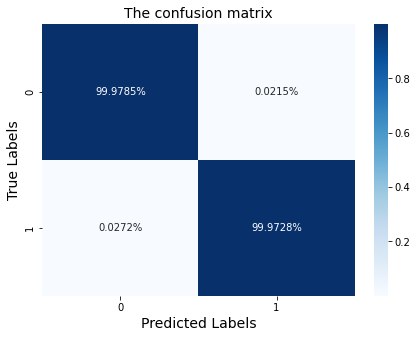

/opt/spark-3.2.0-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


------------------------evaluate the model with test set-----------------------


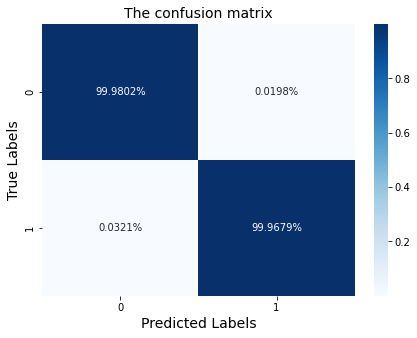

/opt/spark-3.2.0-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


,accuracy,AUC,precision,recall,F-measure
train,0.999785,0.999998,0.944662,0.999728,0.971415
test,0.999801,0.999997,0.948034,0.999679,0.973172


In [14]:
# create a dummy Pandas DF to fill with evaluation metrics later on.
df_eval_metrics = pd.DataFrame(columns=['accuracy', 'AUC', 'precision', 'recall', 'F-measure'])

# evaluate the model with train set
print('evaluate the model with train set'.center(79, "-"))
df_eval_metrics = df_eval_metrics.append(model_test_and_eval(model, train))

# evaluate the model with test set
print('evaluate the model with test set'.center(79, "-"))
df_eval_metrics = df_eval_metrics.append(model_test_and_eval(model, test))

# set the indeces to train & test, so we can recognize them
df_eval_metrics.reset_index(drop=True, inplace=True)
df_eval_metrics.rename({0: 'train', 1: 'test'}, inplace=True)
display(df_eval_metrics)